In [1]:
using Dates
using JLD
"""
    extract_datetime(SAFE_path; start_date=true)
    
    Extracts DateTime from a .SAFE file string. 

    # Arguments
    -`SAFE_path::String`: path to or name of .SAFE file
    -`start_date::Bool`: true for returning start date, false for end date.

    # Output
    - `::DateTime`: Date and time of .SAFE file

# Examples:
```jldoctest
julia> extract_datetime(S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE)
2017-03-09T05:40:35
```
"""
# SAFE_path can be path or SAFE file name, works either way.
function extract_datetime(SAFE_path; start_date=true)
    extract_SAFE_name = split(SAFE_path, "/")[end]
    if start_date
        date_string = split(extract_SAFE_name, "_")[6]
    else
        date_string = split(extract_SAFE_name, "_")[7]
    end
    year = date_string[1:4]
    month = date_string[5:6]
    day = date_string[7:8]
    hour = date_string[10:11]
    minute = date_string[12:13]
    second = date_string[14:end]
    date_int = parse.(Int, [year, month, day, hour, minute, second])
    return DateTime(date_int...)
end

function days_between_acquisitions(date1, date2)
    return Dates.value(Date(date1) - Date(date2))
end

"""
    number_of_SAFE_files(directory)
    
    Counts all .SAFE file names in directory

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `count::Int64`: Number of .SAFE files in directory

# Examples:
```jldoctest
julia> number_of_SAFE_files(/home/directory)
30
```
"""
# counts total number of SAFE files in directory
function number_of_SAFE_files(directory)
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                count += 1
            end
        end
    end
    return count
end

"""
    all_SAFE_files(directory)
    
    returns all .SAFE file names in directory as array

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `all_files::Array{String,N}`: Return .SAFE file names in Array. N is number of files

# Examples:
```jldoctest
julia> file_array = all_SAFE_files(/home/directory)
30-element Array{String,1}:
"S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE"
...
"S1B_IW_SLC__1SDV_20170830T053948_20170830T054014_007165_00CA0A_1DA1.SAFE"
```
"""
function all_SAFE_files(directory)
    all_files = Array{String, 1}(undef, number_of_SAFE_files(directory))
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                all_files[count + 1] = dir
                count += 1
            end
        end
    end
    return all_files
end

"""
    save_as_jld(data, file_name, file_path)

    saves input as .jld file

    # Arguments
    -`data::Any`: Saves input data
    -`file_name::String``: name of file without extension
    -`file_path::String``: path to directory

    # Output
    - None, saves file in file_path

# Examples:
```jldoctest
julia> save_as_jld(data, "data_file_name", "/home/user/result_folder")
```
"""
function save_as_jld(data, file_name, file_path)
    path = joinpath(file_path, file_name*".jld")
    JLD.save(path, "data", data)
end

save_as_jld

In [2]:
"""
    coherence_worker(product_folders, master_view, dem_path, 
                     subswath, result_folder, dem_nan, pod_folder; 
                     kernel = ones(4,14), polarization = ["VV", "VH"], 
                     save_string=["coherence", "intensity", "auxillary"])

Computes and saves coherence, intensities, look up table and auxillary data for a Sentinel-1 image pair

# Arguments
- `product_folders::Array{String,2}`: Array with [master safe file, slave safe file].
- `master_view::Array{UnitRange{Int64},2}`: Master view in (line, sample) coordinates
- `dem_path::String`: The path to the DEM                
- `subswath::Int`: Select a subswath, can be 1, 2 or 3
- `result_folder::String`: Path to directory for saving the results
- `dem_nan::Float`: The value to replace NaN in the DEM.
- `pod_folder::String`: Path to directory with PODs. If PODS are not found, they will be downloaded and saved here.
- `kernel::Array{Float64,2}`: Chosen kernel. Default is ones(4,14) 
- `polarization::Array{String,2}`:  Array with chosen polarizations. Default is ["VV", "VH"]                           
- `save_string::Array{String,3}`: Array with chosen products. Default is ["coherence", "intensity", "auxillary"]

# Output
- None, saves results as .jld in result directory

# Examples:
```jldoctest
julia> master_folder = "/home/directory/S1/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
julia> slave1_folder = "/home/directory/S1/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
julia> product_folders = [master_folder, slave1_folder];
julia> result_folder = "/home/directory/results"
julia> pod_folder = "/home/directory/S1A_POEORB"
julia> dem_path = "/home/directory/dem/srtm_38_01_reprojected.tif"
julia> dem_nan = 40
julia> master_view = [2000-1524:6000-1524, 4801:7801]
julia> coherence_worker(product_folders, master_view, dem_path, 
                        3, result_folder, dem_nan, pod_folder)
```
"""
function coherence_worker(product_folders, master_view, dem_path, 
                          subswath, result_folder, dem_nan, pod_folder; 
                          kernel = ones(4,14), polarization = ["VV", "VH"], 
                          save_string=["coherence", "intensity", "auxillary"])


        for pol in polarization
            println("Processing:", pol)
            # figure out A or B
            master_satellite = string(split(split(product_folders[1], "/")[end], "_")[1][end])
            slave_satellite = string(split(split(product_folders[2], "/")[end], "_")[1][end])

            # get last four digits in file name (identifier)
            master_safe_id = split(split(product_folders[1], "_")[end], ".")[1]
            slave_safe_id = split(split(product_folders[2], "_")[end], ".")[1]

            # compute days between acquisitions:
            master_date = replace.(string(Date(extract_datetime(product_folders[1]))),  "-" => "")
            slave_date = replace.(string(Date(extract_datetime(product_folders[2]))),  "-" => "")
            days_between_acq = string(abs(days_between_acquisitions(extract_datetime(product_folders[1]), extract_datetime(product_folders[2]))))*"d"
            
            # define id strings on format:            
            master_id = "S1"*master_satellite*"_"*pol*"_"*"M"*master_date*"_"*master_safe_id
            slave_id = "S1"*slave_satellite*"_"*pol*"_"*"S"*slave_date*"_"*slave_safe_id
            coherence_id = master_satellite*slave_satellite*"_"*pol*"_"*"M"*master_date*"_"*master_safe_id*"_"*"S"*slave_date*"_"*slave_safe_id*"_"*days_between_acq
            
            # make stride
            stride_line = floor(Int,size(kernel)[1]/2)
            stride_sample = floor(Int,size(kernel)[2]/2)

            # Save folder names, probably overwrites .txt every time, should open and edit if .txt already exists
            folder_names_path = joinpath(result_folder,"product_folders.txt")
            open(folder_names_path, "w") do io
                for folder in product_folders
                    write(io, folder * "\n")
                end
            end;

            # get pod paths
            pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
            
            # get paths
            file_paths = [Load.slc_paths(folder, pol, subswath) for folder in product_folders]
            meta = [Load.slc_meta(path[2]) for path in file_paths]  # path[2] selects meta data
            calibration = [Load.slc_calibration(file_paths[i][3],meta[i]["t_0"]) 
                                        for i in 1:length(product_folders)];
            # load POD
            println("load POD")
            precise_orbit = [Load.precise_orbit(pod_paths[i],meta[i]["t_0"]) 
                                        for i in 1:length(product_folders)]

            # loads DEM, TODO: could be input as well to save loading time
            footprint = SlcUtil.footprint(meta[1], master_view)
            latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
            dem = Load.dem(dem_path, latlon_window; nan_fill = dem_nan, padding=[90,90]);

            println("Coregistering slave")
            slave_data,flat,lut =  coregister_slave(master_view,
                                                    file_paths[2][1],
                                                    meta, precise_orbit, dem)  # meta should be 2 Dict array

            lut_path = joinpath(result_folder, master_id*"_lut.jld")  # consider identifying with m and s dates
            JLD.save(lut_path, "data", lut)

            slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
            flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);
            slave_data = SlcUtil.calibrate_slave_data(slave_data, mosaic_view, lut, calibration[2]);

            master_data = Load.slc_data(file_paths[1][1], master_view);
            master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);
            master_data = SlcUtil.calibrate_data(master_data, Misc.flatten(mosaic_view...)..., calibration[1]);

            println("Compute complex coherence")
            # compute coherence
            complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(
                        master_data, slave_data, flat, kernel, mosaic_view);

            # subsample

            # save
            #coherence_path = joinpath(result_folder, coherence_id*"_coherence.jld")
            if sum(save_string .== "coherence") != 0
                println("Saving complex coherence")
                complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]
                save_as_jld(complex_coherence, coherence_id*"_coherence", result_folder)
            end   

            if sum(save_string .== "intensity") != 0
                println("Saving intensities")
                slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
                save_as_jld(slave_intensity, slave_id*"_intensity", result_folder)
                master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
                save_as_jld(master_intensity, master_id*"_intensity", result_folder)
            end
            
            # TODO: udvid save_as_jld() til at kunne tage flere inputs måske med ...
            if sum(save_string .== "auxillary") != 0
                println("Saving auxillary data")
                lines = lines[1:stride_line:end]
                samples = samples[1:stride_sample:end]

                # save lines and samples 
                line_sample_path = joinpath(result_folder,"line_sample.jld")
                JLD.save(line_sample_path, "lines", lines, "samples", samples)

                # Save heights
                heights = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
                    reshape(lut["heights"],(length(lut["master_line"]),length(lut["master_sample"])))
                    ,lines, samples);

                heights_path = joinpath(result_folder,"heights.jld")
                JLD.save(heights_path, "data", heights)
            end
        end
    return 1
end

coherence_worker

In [3]:
include("../ToolBox/ToolBox.jl")
import FileIO
using .ToolBox
using .Geometry
using .Load
using Colors
import JLD

In [7]:
struct ID
    master_id::String
    #slave_id::"s"
    #coherence_id::"coh"
end

In [18]:
struct Data
  a :: Int64
end
data = Data

ErrorException: type DataType has no field a

In [11]:
master_folder = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
slave1_folder = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
product_folders = [master_folder, slave1_folder];
result_folder = "/home/data/eigil/results/interferogram"
pod_folder = "/home/data/eigil/S1A_POEORB"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"

dem_nan = 40

master_view = [2000-1524:6000-1524, 4801:7801]

2-element Array{UnitRange{Int64},1}:
 476:4476 
 4801:7801

In [141]:
a = Array{UnitRange{Int64},2}(undef, 1, 2)
a[1] = 1:3
a[2] = 3:5
a

1×2 Array{UnitRange{Int64},2}:
 1:3  3:5

In [113]:
# example of saving everything in both polarisations:
coherence_worker(product_folders, master_view, dem_path, 
                       3, result_folder, dem_nan, pod_folder, 
                       kernel = ones(4,14), polarization = ["VV", "VH"], 
                       save_string=["coherence", "intensity", "auxillary"])







load POD
Coregistering slave
Compute complex coherence
Saving complex coherence
Saving intensities
Save auxillary data
load POD
Coregistering slave
Compute complex coherence
Saving complex coherence
Saving intensities
Save auxillary data


1

In [117]:
# example of saving coherence in VV
coherence_worker(product_folders, master_view, dem_path, 
                       3, result_folder, dem_nan, pod_folder, 
                       kernel = ones(4,14), polarization = ["VV"], 
                       save_string=["coherence"])

load POD
Coregistering slave
Compute complex coherence
Saving intensities


1

In [118]:
# example of saving intensity in VH
coherence_worker(product_folders, master_view, dem_path, 
                       3, result_folder, dem_nan, pod_folder, 
                       kernel = ones(4,14), polarization = ["VH"], 
                       save_string=["intensity"])

load POD
Coregistering slave
Compute complex coherence
Saving intensities


1

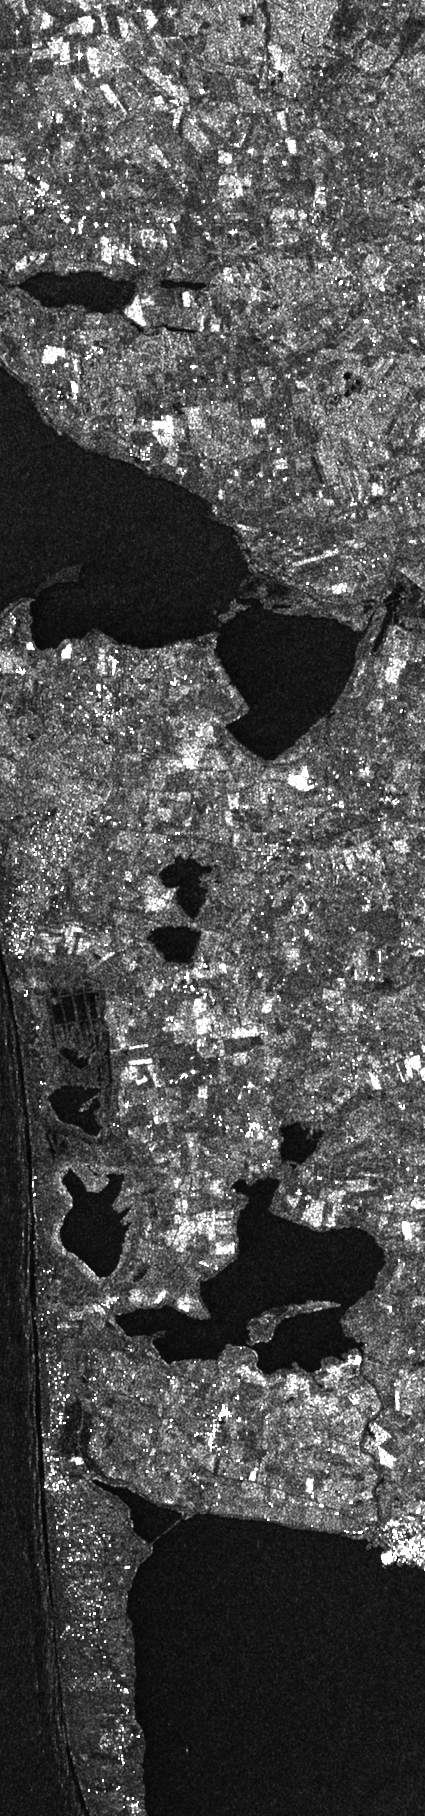

In [119]:
VV = JLD.load("/home/data/eigil/results/interferogram/S1A_VV_M20170321_8439_intensity.jld", "data")[:, end:-1:1];
SlcUtil.show_img(VV)

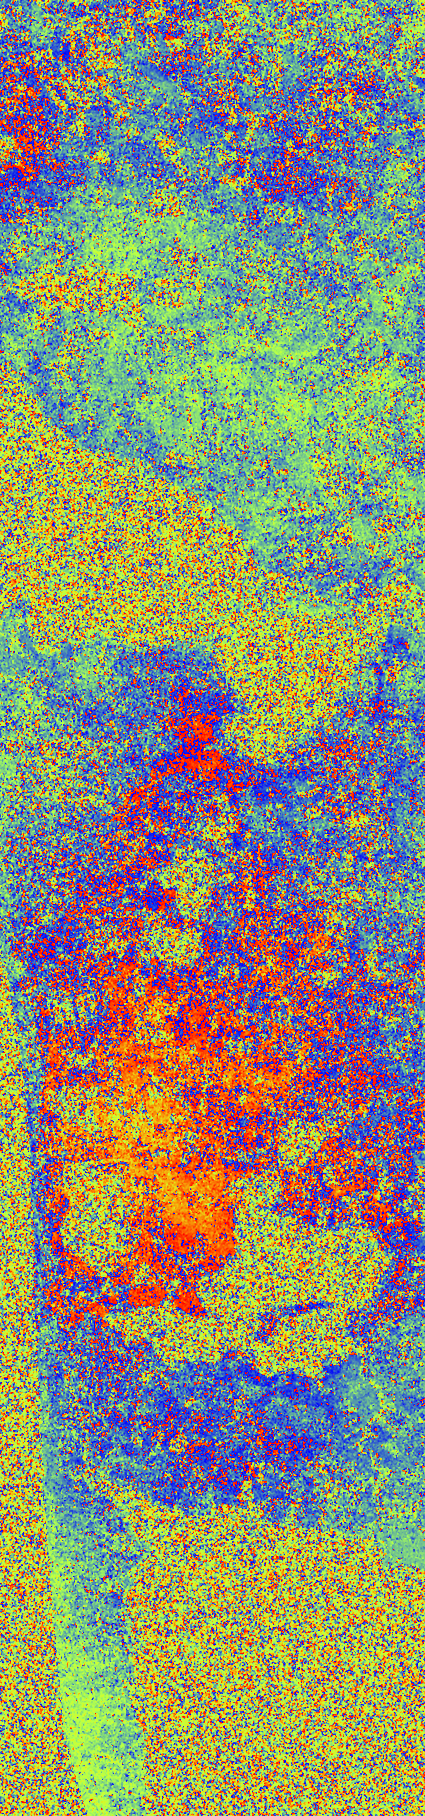

In [115]:
coherence = JLD.load("/home/data/eigil/results/interferogram/AA_VH_M20170321_8439_S20170402_080F_12d_coherence.jld", "data")[:, end:-1:1];
phase_img = SlcUtil.plot_phase(coherence)


In [143]:
typeof(DateTime(1))

DateTime